<a href="https://colab.research.google.com/github/LordLean/Acquired-Intelligence-Adaptive-Behaviour/blob/master/AIAB_Labs/microbialGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output

In [0]:
# (benefit, cost)
knapsack = [(5,3),(6,2),(1,4),(9,5),(2,8),(8,9),(4,10),(3,1),(7,6),(10,7)]
config = {"kp":knapsack, "capacity":20}
crossover = {"One Point":0, "Multi Point":1, "Uniform":2}

In [0]:
class MicrobialGA(object):


  def __init__(self, kp, capacity, crossover_op=0, population_size=100, tournaments=100, mutation_rate=0.3, crossover_rate=0.5):
    self.kp = kp # Knapsack to be evaluated.
    self.capacity = capacity # Knapsack capacity.
    self.crossover_op = crossover_op # Set desired crossover method.
    self.population_size = population_size # Population size for genotypes.
    self.tournaments = tournaments # Tournaments to run for. 
    self.mutation_rate = mutation_rate # Mutation rate to effect rate of evolution.
    self.crossover_rate = crossover_rate # Amend for crossover rate. 
    self.geno_shape = len(self.kp) # Shape of desired genotype.
    self.population = np.zeros(shape=(population_size, self.geno_shape), dtype=int) # Hold all genotypes/solutions.
    # Graphical/not essential Below.
    self.graph_points = np.zeros(shape=(population_size, self.tournaments), dtype=int) # Hold genotype evolutions for graphs.
    self.final_graph_list = list() # Stores only the solutions which reached the below max benefit.
    self.max_val = 0 # Int holder for greatest benefit across all genotypes.
    self.proportion = 0 # Hold value for proportion of genotypes that reached maximum value.


  def initalize(self):
    # Initialze each solution in population to random binary values.
    for i, genotype in enumerate(self.population):
      current_sum = self.capacity + 1 
      # Ensure random values do not cause a cost above capacity.
      while current_sum > self.capacity:
        for i, _ in enumerate(genotype):
          genotype[i] = random.randint(0,1)
          # Update current sum until it holds a value less than capacity.
          current_sum = np.sum([self.kp[i][1] * genotype[i] for i, _ in enumerate(self.kp)])


  # NOT VERY SCALABLE IS IT!
  def selection(self):
    try:
      # Create indicies to compare without out of bounds exception.
      upper_bound = self.population_size - 1
      index_one = random.randint(0,upper_bound)
      index_two = int()
      p = random.uniform(0,1)
      # If p < 1/4 match genotype with previous neighbour at distance 2. 
      if p < 0.25:
        index_two = index_one - 2
      # If 1/4 <= p < 1/2 match genotype with previous neighbour at distance 1. 
      elif p < 0.5:
        index_two = index_one - 1
      # If 1/2 <= p < 3/4 match genotype with next neighbour at distance 1. 
      elif p < 0.75:
        # Try-catch to avoid out of bounds exception. If index does not exist set to 0.
        try:
          index_two = index_one + 1
          # Try catch was maybe not the best solution as had to force a possible error but this was the imp. that I had started.
          geno_one = self.population[index_one] 
          geno_two = self.population[index_two]
          return geno_one, geno_two, index_one, index_two
        except:
          index_two = 0
      # If 3/4 <= p <= 1 match genotype with next neighbour at distance 2. 
      else:
        # Try-catch to avoid out of bounds exception. If index does not exist set to 1.
        try:
          index_two = index_one + 2
          geno_one = self.population[index_one] 
          geno_two = self.population[index_two]
          return geno_one, geno_two, index_one, index_two
        except:
          index_two = 1
      # State the two "neighbouring" genotypes to return.
      geno_one = self.population[index_one] 
      geno_two = self.population[index_two] 
      return geno_one, geno_two, index_one, index_two
    except:
      print("Please pick a population size greater than {}.\nSuggest trying > 2.".format(self.population_size))


  def fitness(self, geno_one, geno_two, index_one, index_two):
    # Fitness returns the better of two genotypes in the form: Winner, loser.
    # Benefit-cost evaluation.
    geno_one_bene = np.sum([self.kp[i][0] * geno_one[i] for i, _ in enumerate(self.kp)])
    geno_one_cost = np.sum([self.kp[i][1] * geno_one[i] for i, _ in enumerate(self.kp)])
    # Benefit-cost evaluation.
    geno_two_bene = np.sum([self.kp[i][0] * geno_two[i] for i, _ in enumerate(self.kp)])
    geno_two_cost = np.sum([self.kp[i][1] * geno_two[i] for i, _ in enumerate(self.kp)])
    # Case: benefits are equal, cost is evaluated.
    if geno_one_bene == geno_two_bene:
      if geno_one_cost <= geno_two_cost:
        return geno_one, geno_two, index_one, index_two
      else:
        return geno_two, geno_one, index_two, index_one
    # If genotype one has a greater benefit then that genotype is returned.
    elif geno_one_bene > geno_two_bene:
      return geno_one, geno_two, index_one, index_two
    # If genotype one has a lesser benefit then that genotype is returned.
    else:
      return geno_two, geno_one, index_two, index_one


  def mutate(self, g, index):
    # Declare variable to hold mutated genotype
    mutated_genotype = np.zeros(self.geno_shape, dtype=int)
    # Setup: while loop.
    current_sum = self.capacity + 1
    # Values will be reassigned until the mutated genotype cost is below capacity.
    while current_sum > self.capacity:
      # Copy genotype to temporary genotype.
      mutated_genotype = np.copy(g)
      for i, _ in enumerate(mutated_genotype):
        num = random.uniform(0,1)  
        # Allow mutation rate to reassign values.
        if num < self.mutation_rate:
          # If "on" switch off.
          if mutated_genotype[i]:
            mutated_genotype[i] = 0
          # If "off" switch on.
          else:
            mutated_genotype[i] = 1
      # Update current sum for the while loop to evaluate.
      current_sum =  np.sum([self.kp[i][1] * mutated_genotype[i] for i, _ in enumerate(self.kp)])
    self.population[index] = mutated_genotype
    return self.population[index]
    
  
  def crossover(self, geno_one, geno_two):
    # One Point Crossover.
    if self.crossover_op == 0:
      # Ensure crossed over genotype does not break capacity.
      current_sum = self.capacity + 1
      while current_sum > self.capacity:
        # Find index to split winning genotype portion for crossover.
        upper_bound = self.geno_shape
        cross_index = random.randint(-upper_bound, upper_bound)
        if cross_index <= 0:
          geno_two[:cross_index] = geno_one[:cross_index]
        else:
          geno_two[cross_index:] = geno_one[cross_index:]
        # Recompute current cost sum.
        current_sum =  np.sum([self.kp[i][1] * geno_two[i] for i, _ in enumerate(self.kp)])
    # Multi Point Crossover.
    elif self.crossover_op == 1:
      # Ensure crossed over genotype does not break capacity.
      current_sum = self.capacity + 1
      while current_sum > self.capacity:
        # Find index to split winning genotype portion for crossover.
        upper_bound = self.geno_shape
        cross_index_list = np.random.randint(0, upper_bound, 2)
        # Two values for array slicing to crossover winning genes.
        lower_slice, upper_slice = sorted(cross_index_list)
        # Copy over genes from winning solution to loser within slice bounds.
        geno_two[lower_slice:upper_slice] = geno_one[lower_slice:upper_slice]
        # Recompute current cost sum.
        current_sum =  np.sum([self.kp[i][1] * geno_two[i] for i, _ in enumerate(self.kp)])
    # Uniform Crossover.
    elif self.crossover_op == 2:
      # Ensure crossed over genotype does not break capacity.
      current_sum = self.capacity + 1
      while current_sum > self.capacity:
        for i, (winning_gene, _) in enumerate(zip(geno_one,geno_two)):
          # Calc p value for whether winning gene gets copied over.
          num = random.uniform(0,1)
          # 50/50 should average to a similar amount of genes being changed as the other two cross operators.
          if num < 0.5:
            geno_two[i] = winning_gene
        # Recompute current cost sum.
        current_sum =  np.sum([self.kp[i][1] * geno_two[i] for i, _ in enumerate(self.kp)])
    return geno_one, geno_two


  def final_graphs(self, distance_from_max):
    # Find maximum benefit from current solutions.    
    self.max_val = np.amax(self.graph_points)
    # Find genotypes that end with benefit within a defined bound from max.
    for graph in self.graph_points:
      if graph[-1] >= self.max_val - distance_from_max:
        self.final_graph_list.append(graph)
        self.proportion += 1


  def evolve(self,dist=0):
    # Tournaments to run for.
    runs = self.tournaments
    # tourney_counter to store generations for graphical representation.
    tourney_counter = 0
    # Initalize population.
    self.initalize()
    for _ in range(runs):
      # Select and compare two random solutions.
      geno_one, geno_two, index_one, index_two = self.selection()
      # Winner, Loser
      geno_one, geno_two, index_one, index_two = self.fitness(geno_one, geno_two, index_one, index_two)
      # Calc probability of crossover occuring.
      crossover_p_value = random.uniform(0,1)
      if crossover_p_value < self.crossover_rate:
        # Crossover winning genes to loser genotype.
        geno_one, geno_two = self.crossover(geno_one, geno_two)
      # Mutate the crossed over loser genotype.
      geno_two = self.mutate(geno_two, index_two)

      # Pull current benefits from each solution for graphical rep.
      for index in range(self.population_size):
        benefit = np.sum([self.kp[i][0] * self.population[index][i] for i, _ in enumerate(self.kp)])
        self.graph_points[index][tourney_counter] = benefit
      # Add to tourney counter.
      tourney_counter += 1
    # Call final_graphs() to calculate necessary values for graphical rep.
    self.final_graphs(dist)


In [4]:
# This cell demonstates the microbialGA classes' functions individually.

# Demonstration of initalize() method.
try:
  method = input("Select crossover operator, available options are: \nOne Point \nMulti Point \nUniform\n")
  method = method.title().strip()
  crossover_operation = crossover[method]
  clear_output()
  print("Crossover method {} selected.".format(method))
except:
  clear_output()
  method = "One Point"
  print("Invalid keyboard input. Default method {} selected.".format(method))
  crossover_operation = crossover[method]
print()
mga = MicrobialGA(config["kp"], config["capacity"], crossover_op=crossover_operation, population_size=4, crossover_rate=1)
print("Initial empty solutions")
print(mga.population)
mga.initalize()
print("\ninitalize()")
print(mga.population,"\n")

# Demonstration of selection() and fitness() methods:
print("selection()")
one, two, index_one, index_two = mga.selection()
ONE = np.sum([mga.kp[i][0] * one[i] for i, _ in enumerate(mga.kp)])
TWO = np.sum([mga.kp[i][0] * two[i] for i, _ in enumerate(mga.kp)])
print("Array One: {} and Array Two: {} \n".format(one,two))
print("Array One Benefit: {} and Array Two Benefit: {}\n".format(ONE,TWO))
print("fitness()")
one, two, index_one, index_two = mga.fitness(one, two, index_one, index_two)
print("Array One: {} and Array Two: {}\n".format(one,two))

# Demonstration of crossover() method.
print("crossover()")
print("Selected method: {}\n".format(method))
print("Array One: {} \nArray Two: {} \n".format(one,two))
x,y = mga.crossover(one,two)
print("Array One: {} \nArray Two: {} \n".format(x,y))

Crossover method Uniform selected.

Initial empty solutions
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]

initalize()
[[1 1 0 0 1 0 0 0 0 1]
 [1 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 1 0]
 [1 0 1 0 0 0 0 0 1 1]] 

selection()
Array One: [1 1 0 0 1 0 0 0 0 1] and Array Two: [0 0 0 0 0 1 0 0 1 0] 

Array One Benefit: 23 and Array Two Benefit: 15

fitness()
Array One: [1 1 0 0 1 0 0 0 0 1] and Array Two: [0 0 0 0 0 1 0 0 1 0]

crossover()
Selected method: Uniform

Array One: [1 1 0 0 1 0 0 0 0 1] 
Array Two: [0 0 0 0 0 1 0 0 1 0] 

Array One: [1 1 0 0 1 0 0 0 0 1] 
Array Two: [1 1 0 0 0 0 0 0 1 0] 



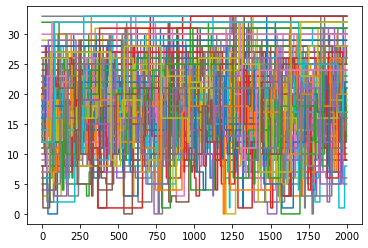

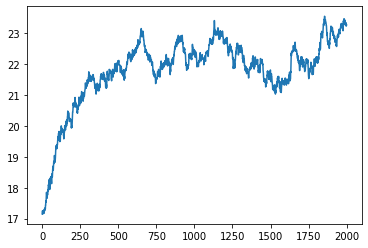

Below shows the top 20 performing genotypes.


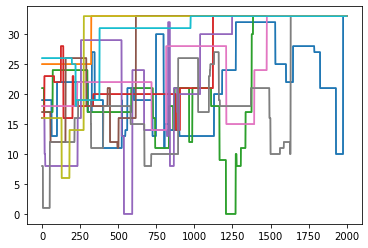

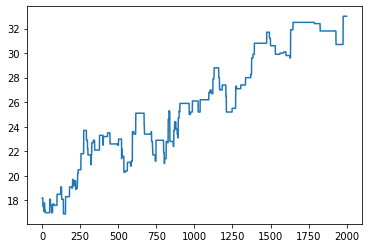

In [5]:
tourn = 2000 
pop = 100
mga = MicrobialGA(config["kp"], config["capacity"], crossover["One Point"], mutation_rate=0.25, tournaments=tourn, population_size=pop)
mga.evolve()
mga.final_graphs(distance_from_max=0)

# Covers the x axis range (num of tournaments) for both sets of graphs.
data_x = np.arange(0,mga.tournaments)

# Plot all solutions evolutions.
for i, _ in enumerate(mga.graph_points):
  data_y = mga.graph_points[i]
  plt.plot(data_x, data_y)
plt.show()


# Plot the average of those solutions.
avg = list()
for i in range(mga.tournaments):
  ls = list()
  for array in mga.graph_points:
    ls.append(array[i])
  avg_by_index = sum(ls)/len(ls)
  avg.append(avg_by_index)
plt.plot(data_x,avg)
plt.show()

print("Below shows the top {} performing genotypes.".format(mga.proportion))

# Plot solutions that ended with a value within a set bound from maximum benefit.
for graph_vals in mga.final_graph_list:
  data_y = graph_vals
  plt.plot(data_x, data_y)
plt.show()


try:
  # Plot the average of those "successful" solutions.
  avg = list()
  for i in range(mga.tournaments):
    ls = list()
    for array in mga.final_graph_list:
      ls.append(array[i])
    avg_by_index = sum(ls)/len(ls)
    avg.append(avg_by_index)
  plt.plot(data_x,avg)
  plt.show()
except:
  print()
  print("Please try values higher than {} for population size for this half of demo.".format(tourn,pop))

In [6]:
final_solution_list = list()
curr_max = 0
poss_solution = np.zeros(10,dtype=int)

for solution in mga.population:
  val = np.sum([mga.kp[i][0] * solution[i] for i, _ in enumerate(mga.kp)])
  if val > curr_max:
    curr_max = val
    poss_solution = solution

  final_solution_list.append(val)

print(curr_max)

counter = list()
for item in final_solution_list:
  if item == curr_max:
    counter.append(item)

print("{} out of {} \"best\" solutions reached the maximum value of: {}".format(len(counter),mga.proportion,mga.max_val))
print("Possible solution : {}".format(poss_solution))

33
10 out of 20 "best" solutions reached the maximum value of: 33
Possible solution : [1 1 0 1 0 0 0 1 0 1]


In [7]:
for solution in mga.population:
  val = np.sum([mga.kp[i][0] * solution[i] for i, _ in enumerate(mga.kp)])
  print(solution, val)

[0 1 1 1 0 0 0 1 1 0] 26
[1 1 0 1 0 0 0 1 1 0] 30
[0 1 0 1 0 0 0 0 1 1] 32
[1 0 0 0 1 0 0 0 0 1] 17
[0 0 0 1 1 0 0 1 1 0] 21
[0 0 0 1 0 0 0 1 1 1] 29
[0 1 0 0 0 0 1 1 0 1] 23
[1 1 0 1 0 1 0 1 0 0] 31
[1 1 0 0 0 0 0 1 1 1] 31
[0 0 0 0 0 0 1 1 0 1] 17
[1 1 0 1 0 0 0 1 0 1] 33
[1 1 0 1 0 0 0 1 0 1] 33
[1 0 0 1 0 0 0 1 0 1] 27
[0 0 0 0 0 0 0 1 1 0] 10
[0 0 1 1 0 0 0 1 1 0] 20
[1 1 0 0 0 0 0 1 1 1] 31
[1 1 0 0 1 0 0 0 0 0] 13
[1 0 0 0 0 0 1 0 0 0] 9
[1 1 0 1 0 1 0 1 0 0] 31
[0 0 1 0 0 0 0 0 1 0] 8
[1 0 0 0 0 1 0 0 0 1] 23
[1 1 1 0 0 0 0 0 0 1] 22
[1 1 0 1 0 0 0 0 0 1] 30
[1 1 0 0 0 0 0 0 1 1] 28
[0 1 0 1 0 0 0 1 0 1] 28
[0 0 0 1 0 0 0 0 1 1] 26
[0 1 1 1 0 0 0 0 0 1] 26
[0 1 0 0 1 0 0 1 0 0] 11
[1 1 0 1 0 0 0 1 0 1] 33
[1 1 0 1 0 0 0 1 0 1] 33
[0 1 0 1 0 0 0 1 0 1] 28
[0 0 0 0 0 0 0 0 0 1] 10
[1 1 0 0 1 0 0 0 0 1] 23
[0 1 0 0 0 1 0 1 0 0] 17
[0 1 0 0 0 1 0 1 1 0] 24
[1 0 1 0 0 0 0 0 1 0] 13
[1 1 0 1 0 1 0 1 0 0] 31
[0 1 0 1 0 0 0 0 1 1] 32
[1 1 0 0 0 0 0 1 1 1] 31
[0 1 1 0 0 0 0 0 1 1] 24
[1